In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [2]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [4]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [5]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [23]:
def yield_batch(data, batch):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, batch)
        x = feat.loc[item_id]
        y = answers.loc[item_id]
        yield x, y

In [41]:
def yield_batch_val(data):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = set(votes.index)
    while True:
        x = feat.loc[[item_ids]]
        y = answers.loc[[item_ids]]
        yield x, y

In [40]:
def yield_batch_test(data):
    counts = data[["userId"]].groupby("itemId").count()
    feat = data.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = data.index.unique()
    for item_id in item_ids:
        x = feat.loc[[item_id]]
        yield x

In [14]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [21]:
def make_model(units):
    K.clear_session()
    
    y = x = layers.Input(shape=(21,))
    
    y = layers.Dense(
        units=units * 8,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [16]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [17]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0
        self.d_loss = 0
        self.d_iterations = 0
        self.d_iterations2 = 0
        self.d_1 = 0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        print()
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [57]:
def train_model(data_train, data_val, units, batch, test=False):
    
    max_lr = 3.9e-03
    
    steps_per_epoch = 1000 // batch
    epochs = 40
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train, batch),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=1,
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model1.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train, batch),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=1,
        )
    
    model = models.load_model("../processed/model1.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [47]:
FOLDS = 10

def train_oof(train_set, test_set, units=16, batch=1):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units, batch)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {np.std(scores):0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 13,748
Trainable params: 13,748
Non-trainable params: 0
_________________________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.3335 - val_loss: -0.2272

Epoch 00001: val_loss improved from inf to -0.22724, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0162

Epoch 2/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3775 - val_loss: -0.4290

Epoch 00002: val_loss improved from -0.22724 to -0.42902, saving model to ../processed/model1.h5
Learning rate: 3.7e-03
Speed per epoch: -0.0453

Epoch 3/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4084 - val_loss: -0.3996

Epoch 00003: val_loss did not improve from -0.42902
Learning rate: 3.7e-03
Speed per epoch: -0.0332

Epoch 4/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4500 - val_loss: -0.4110

Epoch 00004: val_loss did not improve from -0.42902
Learning rate: 3.7e-03
Speed per epoch: -0.0324

Epoch 5/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4459 - val_loss: -0.501

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5762 - val_loss: -0.5920

Epoch 00038: val_loss did not improve from -0.59251
Learning rate: 8.0e-05
Speed per epoch: 0.0000

Epoch 39/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5768 - val_loss: -0.5925

Epoch 00039: val_loss did not improve from -0.59251
Learning rate: 3.5e-05
Speed per epoch: 0.0001

Epoch 40/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5809 - val_loss: -0.5923

Epoch 00040: val_loss did not improve from -0.59251
Learning rate: 2.2e-05
Speed per epoch: -0.0012


Fold - 2 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
________________________________________________

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5566 - val_loss: -0.5707

Epoch 00029: val_loss improved from -0.56707 to -0.57067, saving model to ../processed/model1.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0045

Epoch 30/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5556 - val_loss: -0.5553

Epoch 00030: val_loss did not improve from -0.57067
Learning rate: 7.9e-04
Speed per epoch: -0.0020

Epoch 31/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5481 - val_loss: -0.5716

Epoch 00031: val_loss improved from -0.57067 to -0.57160, saving model to ../processed/model1.h5
Learning rate: 4.6e-04
Speed per epoch: 0.0007

Epoch 32/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5687 - val_loss: -0.5771

Epoch 00032: val_loss improved from -0.57160 to -0.57711, saving model to ../processed/model1.h5
Learning rate: 4.1e-04
Speed per epoch: -0.0102

Epoch 33/40
1000/1000 [===========================

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5191 - val_loss: -0.5353

Epoch 00020: val_loss did not improve from -0.54805
Learning rate: 1.5e-03
Speed per epoch: 0.0046

Epoch 21/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5381 - val_loss: -0.5530

Epoch 00021: val_loss improved from -0.54805 to -0.55295, saving model to ../processed/model1.h5
Learning rate: 1.1e-03
Speed per epoch: -0.0053

Epoch 22/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5411 - val_loss: -0.5558

Epoch 00022: val_loss improved from -0.55295 to -0.55581, saving model to ../processed/model1.h5
Learning rate: 1.1e-03
Speed per epoch: -0.0089

Epoch 23/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5379 - val_loss: -0.5508

Epoch 00023: val_loss did not improve from -0.55581
Learning rate: 1.1e-03
Speed per epoch: -0.0029

Epoch 24/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5418 - val_loss

Epoch 1/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.2714 - val_loss: -0.3282

Epoch 00001: val_loss improved from inf to -0.32816, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.2116

Epoch 2/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3807 - val_loss: -0.4178

Epoch 00002: val_loss improved from -0.32816 to -0.41784, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0958

Epoch 3/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4141 - val_loss: -0.3584

Epoch 00003: val_loss did not improve from -0.41784
Learning rate: 3.9e-03
Speed per epoch: -0.0407

Epoch 4/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4471 - val_loss: -0.4101

Epoch 00004: val_loss did not improve from -0.41784
Learning rate: 3.9e-03
Speed per epoch: -0.0395

Epoch 5/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4376 - val_l

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5807 - val_loss: -0.5791

Epoch 00038: val_loss did not improve from -0.58118
Learning rate: 4.0e-05
Speed per epoch: 0.0008

Epoch 39/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5870 - val_loss: -0.5755

Epoch 00039: val_loss did not improve from -0.58118
Learning rate: 2.9e-05
Speed per epoch: -0.0010

Epoch 40/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5838 - val_loss: -0.5797

Epoch 00040: val_loss did not improve from -0.58118
Learning rate: 2.3e-05
Speed per epoch: 0.0024


Fold - 6 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
________________________________________________

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5780 - val_loss: -0.5344

Epoch 00029: val_loss improved from -0.52959 to -0.53441, saving model to ../processed/model1.h5
Learning rate: 3.3e-04
Speed per epoch: -0.0040

Epoch 30/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5681 - val_loss: -0.5340

Epoch 00030: val_loss did not improve from -0.53441
Learning rate: 2.3e-04
Speed per epoch: 0.0020

Epoch 31/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5861 - val_loss: -0.5321

Epoch 00031: val_loss did not improve from -0.53441
Learning rate: 2.0e-04
Speed per epoch: -0.0050

Epoch 32/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5825 - val_loss: -0.5298

Epoch 00032: val_loss did not improve from -0.53441
Learning rate: 2.0e-04
Speed per epoch: -0.0013

Epoch 33/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5847 - val_loss: -0.5365

Epoch 00033: val_loss improved fro

1000/1000 [==============================] - 5s 5ms/step - loss: -0.4734 - val_loss: -0.4695

Epoch 00010: val_loss did not improve from -0.49293
Learning rate: 3.8e-03
Speed per epoch: -0.0062

Epoch 11/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4805 - val_loss: -0.4880

Epoch 00011: val_loss did not improve from -0.49293
Learning rate: 3.8e-03
Speed per epoch: -0.0070

Epoch 12/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4756 - val_loss: -0.4691

Epoch 00012: val_loss did not improve from -0.49293
Learning rate: 2.8e-03
Speed per epoch: -0.0056

Epoch 13/40
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4931 - val_loss: -0.4734

Epoch 00013: val_loss did not improve from -0.49293
Learning rate: 2.8e-03
Speed per epoch: -0.0090

Epoch 14/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.4982 - val_loss: -0.4877

Epoch 00014: val_loss did not improve from -0.49293
Learning rate: 2.8e-03
Spe

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5833 - val_loss: -0.5155

Epoch 00037: val_loss did not improve from -0.52176
Learning rate: 2.6e-05
Speed per epoch: -0.0002

Epoch 38/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5831 - val_loss: -0.5158

Epoch 00038: val_loss did not improve from -0.52176
Learning rate: 1.9e-05
Speed per epoch: 0.0041

Epoch 39/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5828 - val_loss: -0.5178

Epoch 00039: val_loss did not improve from -0.52176
Learning rate: 8.2e-06
Speed per epoch: 0.0026

Epoch 40/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5891 - val_loss: -0.5189

Epoch 00040: val_loss did not improve from -0.52176
Learning rate: 6.1e-06
Speed per epoch: -0.0002


Fold - 10 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5619 - val_loss: -0.5174

Epoch 00028: val_loss did not improve from -0.54636
Learning rate: 7.9e-04
Speed per epoch: -0.0033

Epoch 29/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5593 - val_loss: -0.5351

Epoch 00029: val_loss did not improve from -0.54636
Learning rate: 7.7e-04
Speed per epoch: -0.0029

Epoch 30/40
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5622 - val_loss: -0.5449

Epoch 00030: val_loss did not improve from -0.54636
Learning rate: 7.0e-04
Speed per epoch: 0.0000

Epoch 31/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5604 - val_loss: -0.5353

Epoch 00031: val_loss did not improve from -0.54636
Learning rate: 4.7e-04
Speed per epoch: 0.0006

Epoch 32/40
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5727 - val_loss: -0.5530

Epoch 00032: val_loss improved from -0.54636 to -0.55303, saving model to ../pro

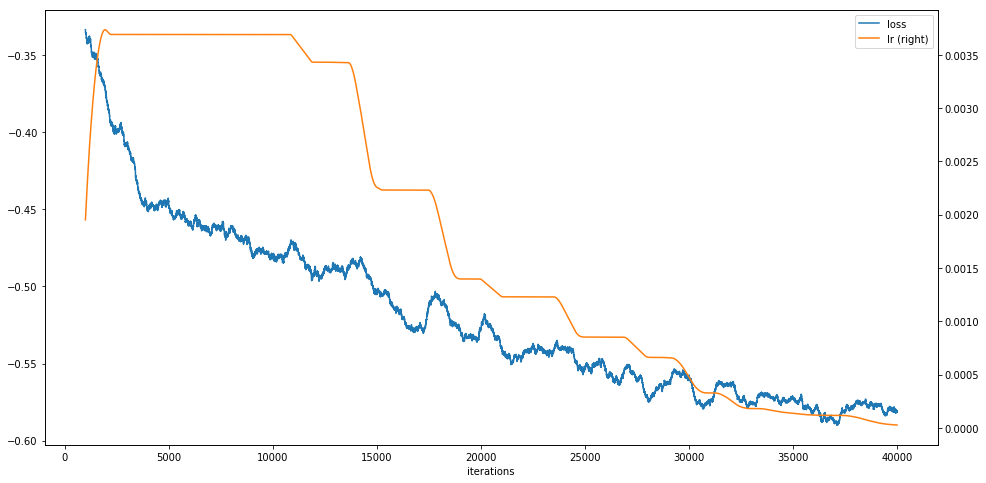

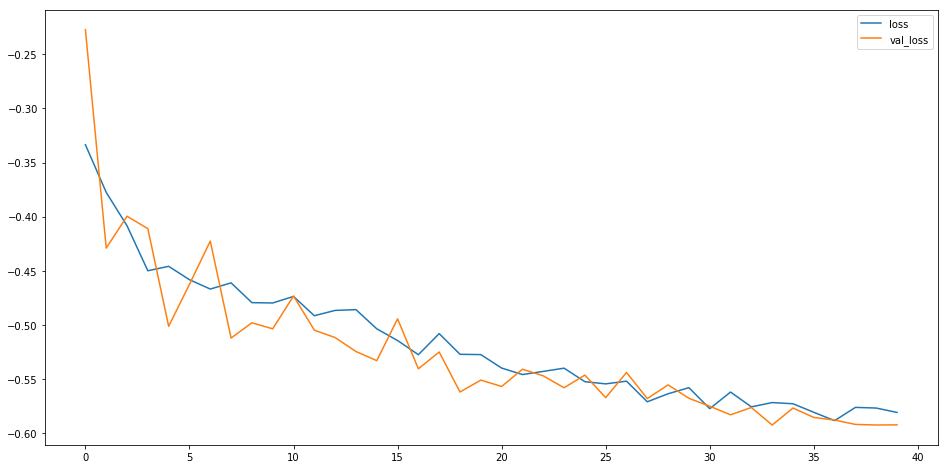

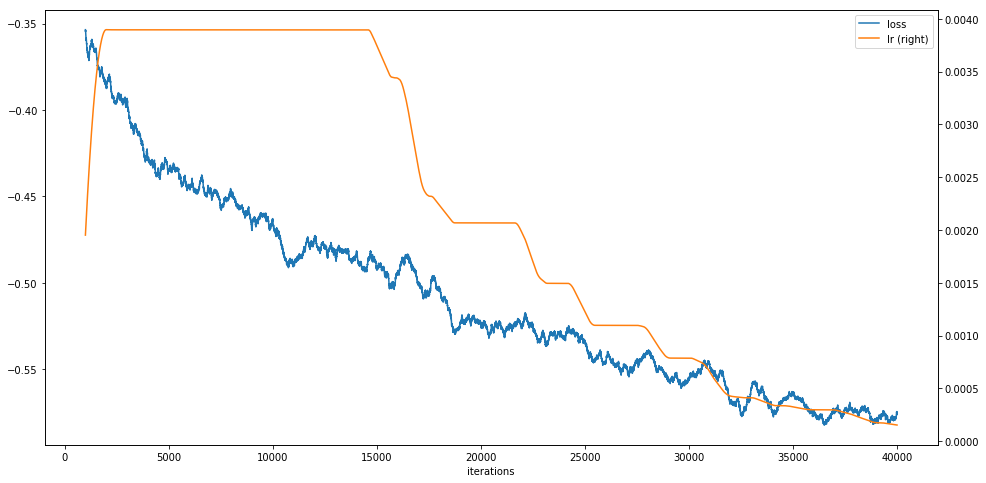

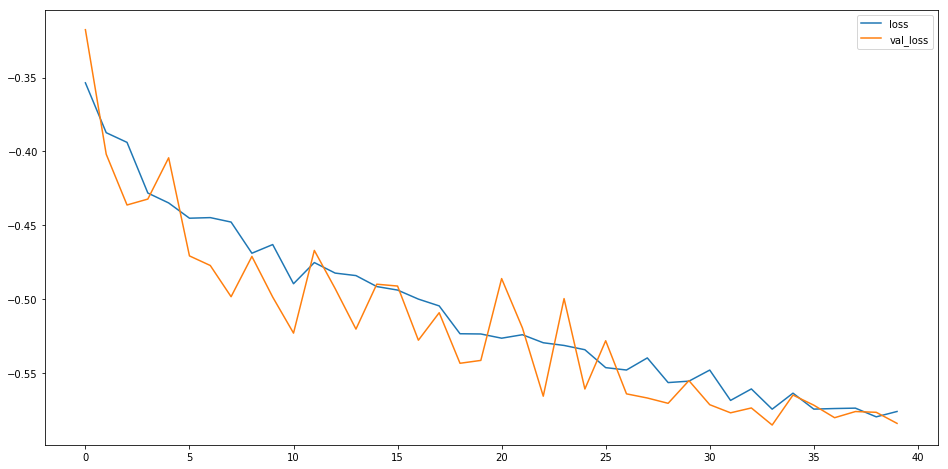

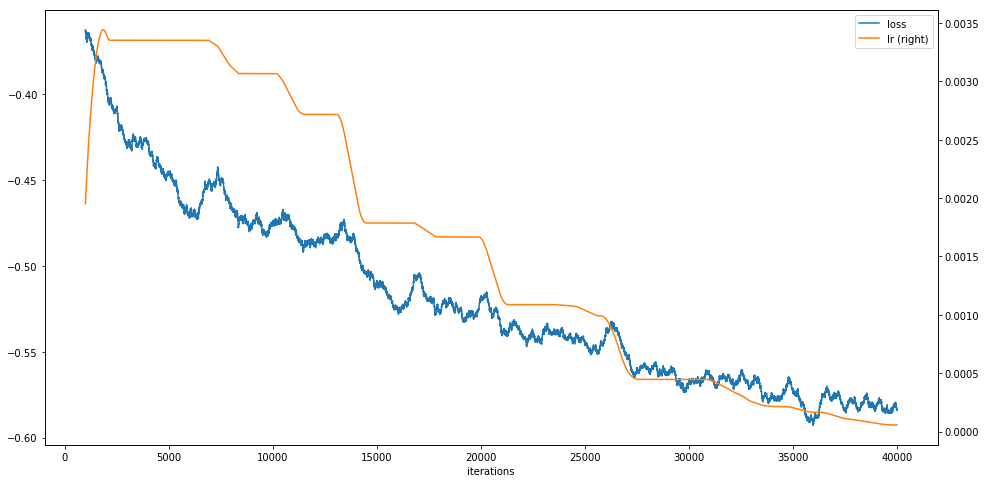

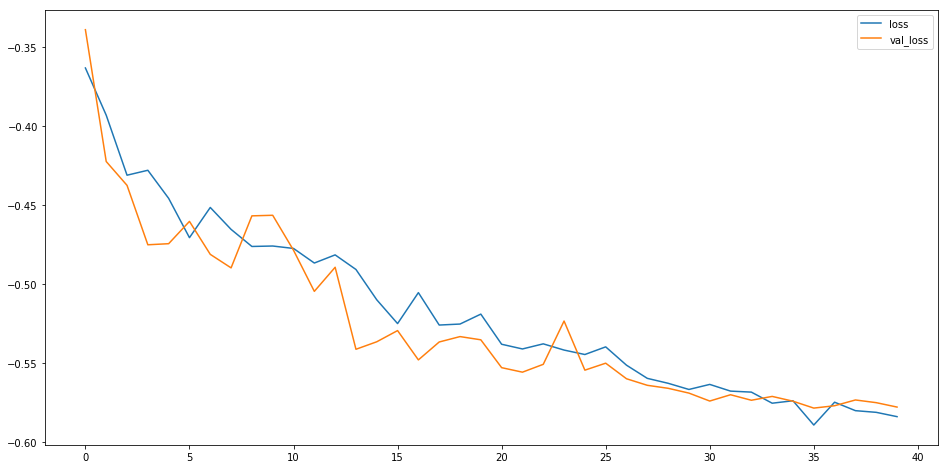

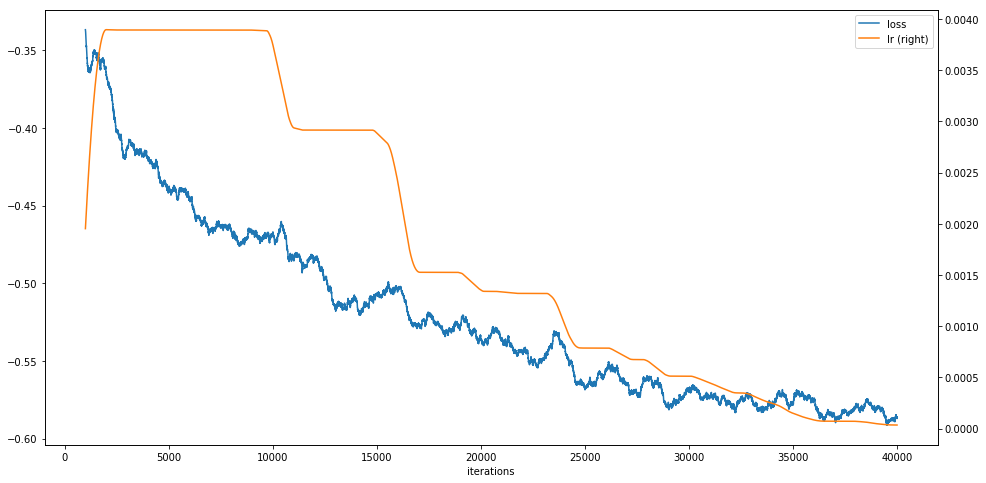

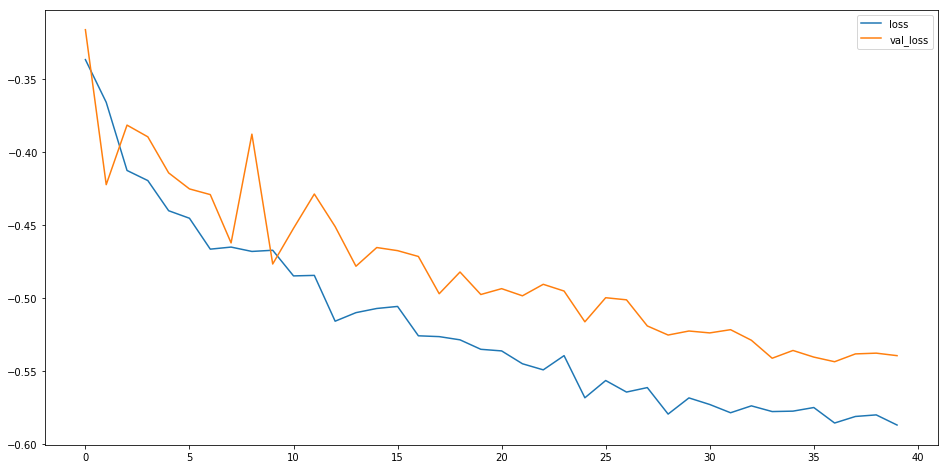

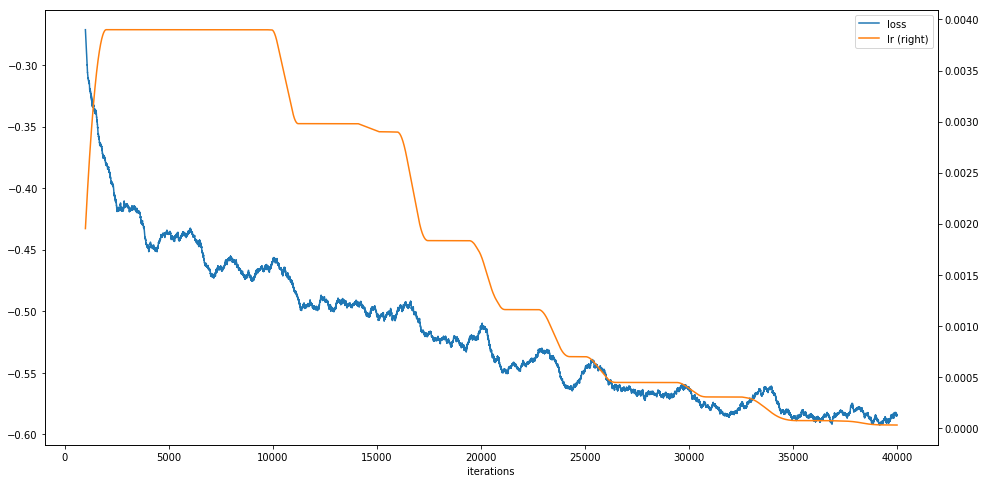

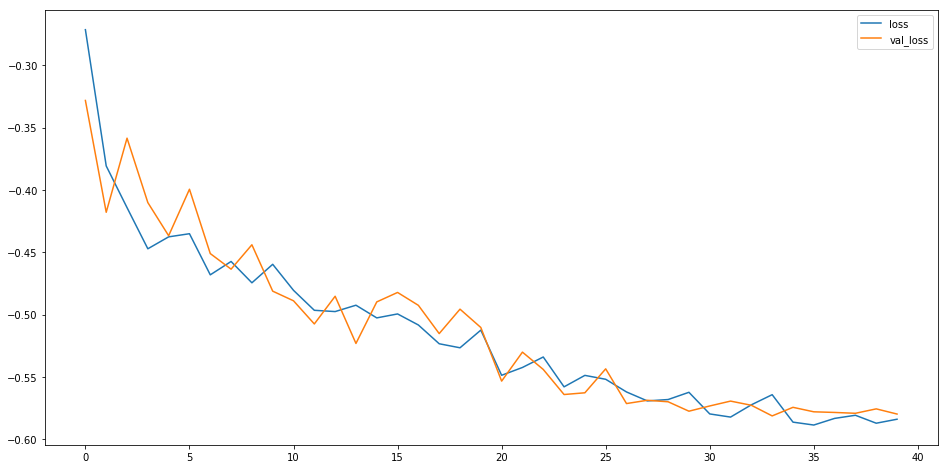

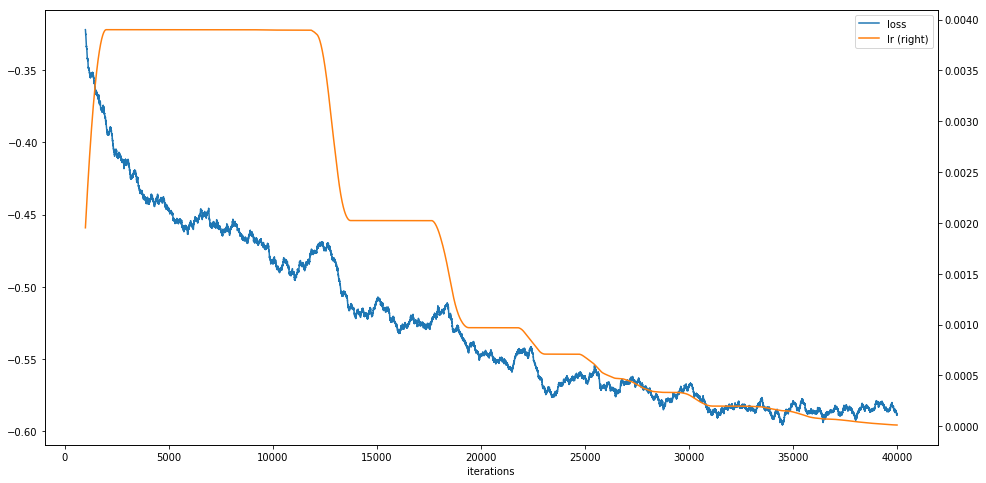

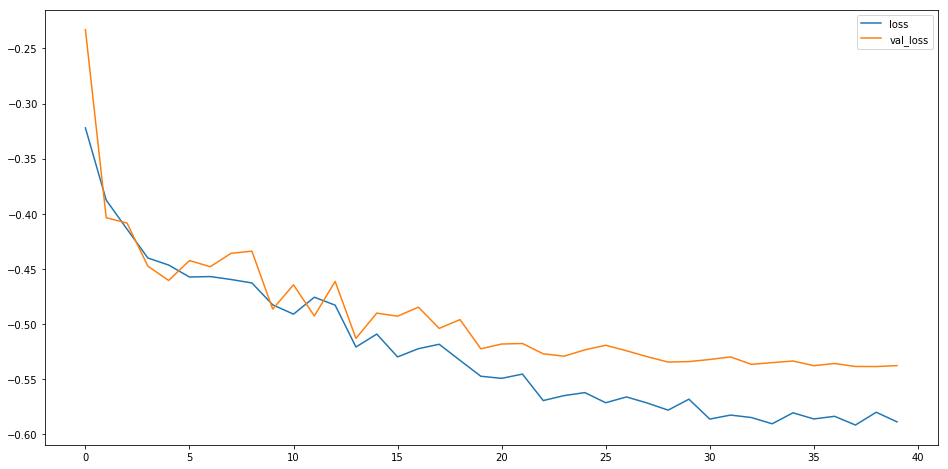

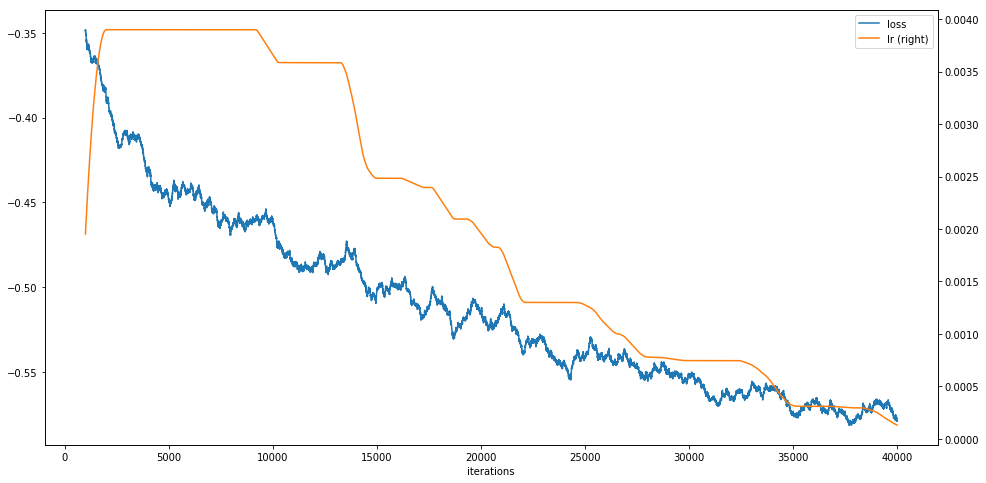

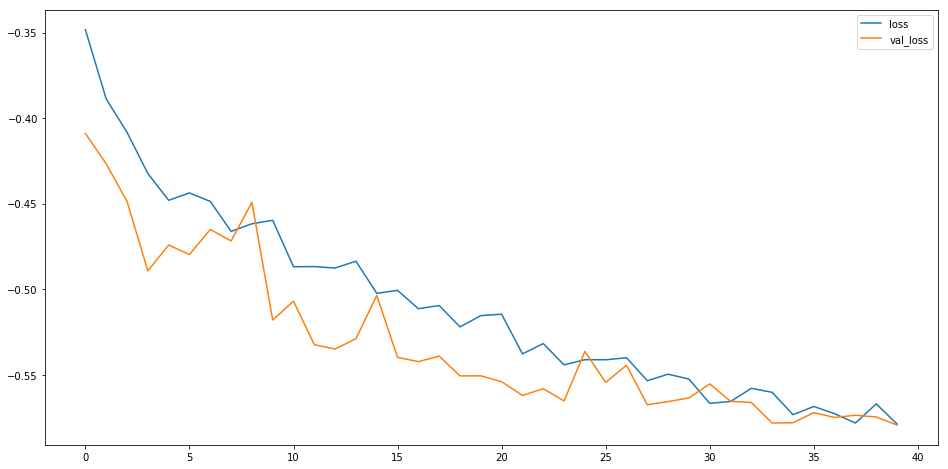

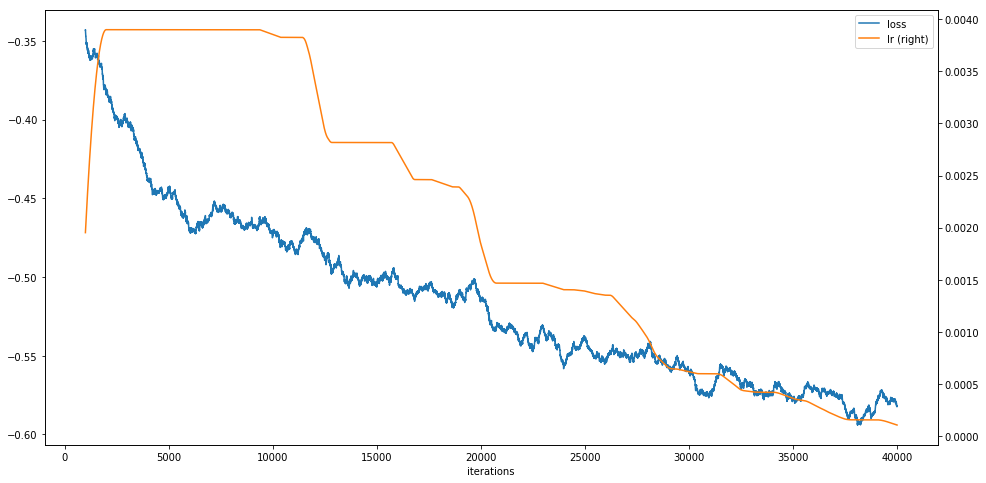

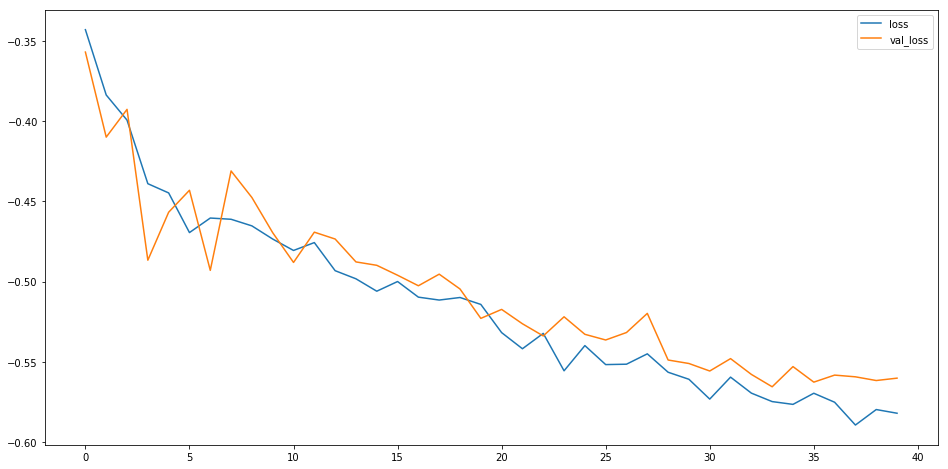

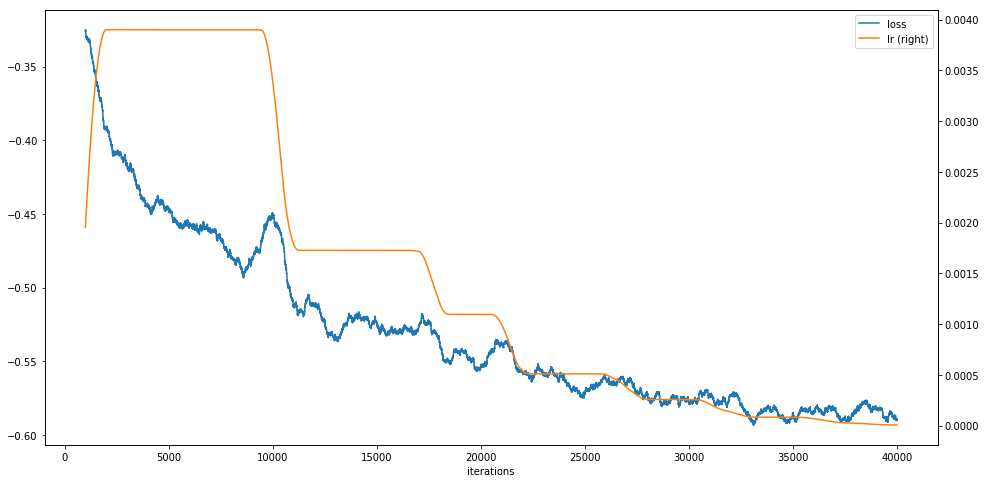

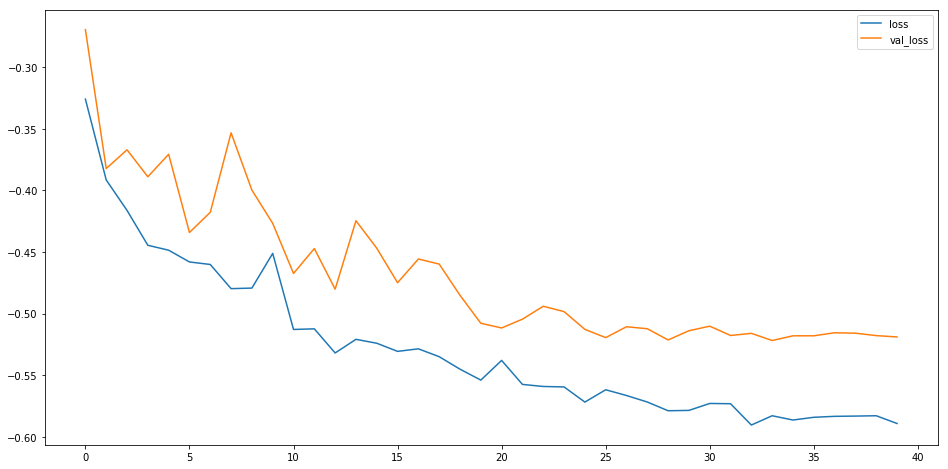

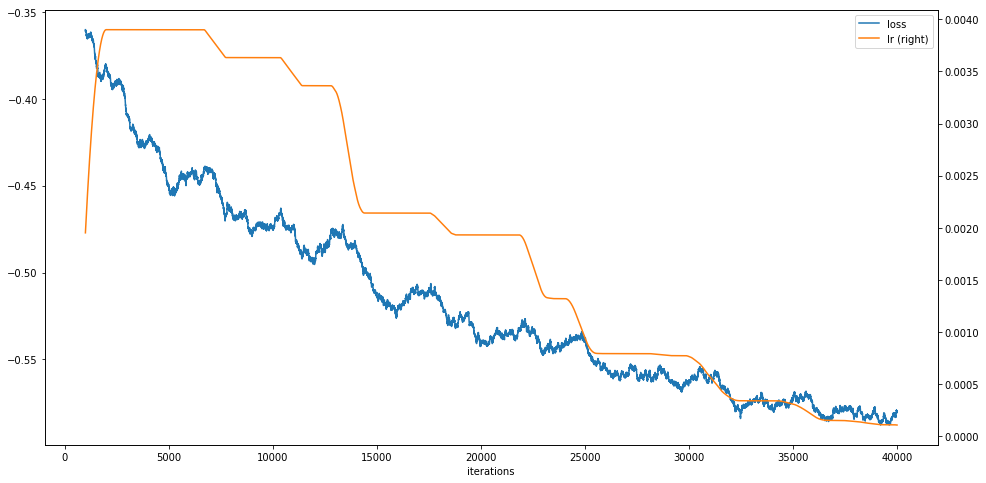

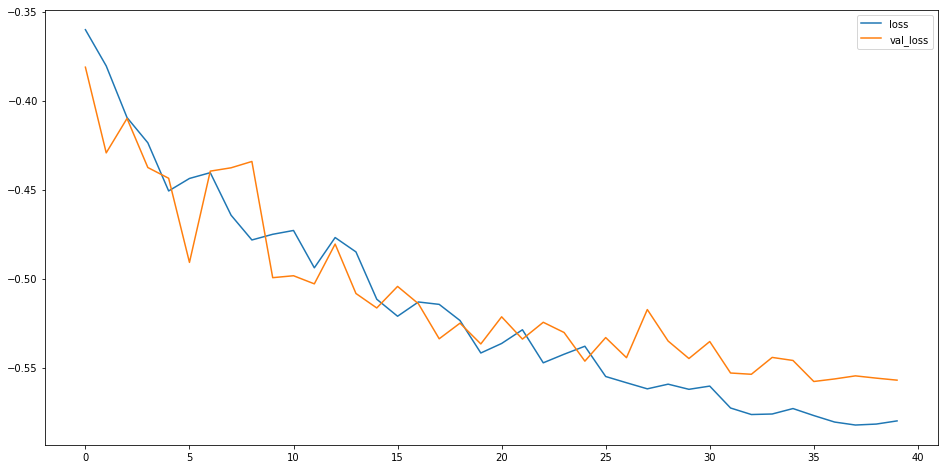

In [55]:
train_oof((votes, answers), votes_test)